In [1]:
import os
import scipy.io
import numpy as np
import statistics, math
import matplotlib.pyplot as plt
from libs import util_matlab as umatlab
from libs import datasets, dataset_utils, utils
import tensorflow as tf

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

/Users/alfonso/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/alfonso/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [5]:
data_dir="/Users/alfonso/matlab/IndirectAcquisition/keras/dataforMarius/export"
files = [os.path.join(data_dir, file_i) for file_i in os.listdir(data_dir) if file_i.endswith('.mat')]

matlabStruct=umatlab.loadmat(files[1]).get('data')
energyBand=matlabStruct.get('energyBand')
energyBand=(energyBand /100 )+1 #normalize [0-1]
totalSecs=matlabStruct.get('waveIn').shape[0]/matlabStruct.get('audioSR')
energyBands_sr=energyBand.shape[1]/totalSecs #This is around 100Hz-10ms
controlNames=matlabStruct.get('controlNames')
controlData=matlabStruct.get('controlData')
string=controlData[0,:]
#pitch=controlData[6,:]/1500

Buil the DataSet

In [83]:
joinWithPitch = 0

Xs = []
ys = []
n_input=energyBand.shape[0] #+1
# Let's start with the music files
for filename in files[1:2]:
    #print(filename)
    matlabStruct=umatlab.loadmat(filename).get('data')
    energyBand=(matlabStruct.get('energyBand')/120)+1
    controlData=matlabStruct.get('controlData')
    controlNames=matlabStruct.get('controlNames')
    string=controlData[0,:]
    pitch=controlData[6,:]/1500
    
    for iframe in range(len(string)):
        frame = energyBand[:,iframe]
        if (joinWithPitch):
            frame=np.append(frame, pitch[iframe])
        
        Xs.append(frame)
        ys.append(int(string[iframe]))
    

        
Xs = np.array(Xs)
ys = np.array(ys)
print(Xs.shape, ys.shape)

(2001, 40) (2001,)


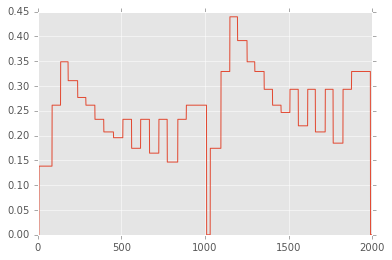

In [8]:
plt.plot(pitch)

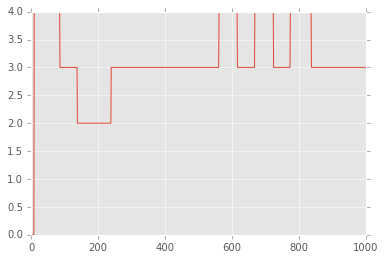

In [7]:
plt.plot(ys[1:1000])

Build the Network

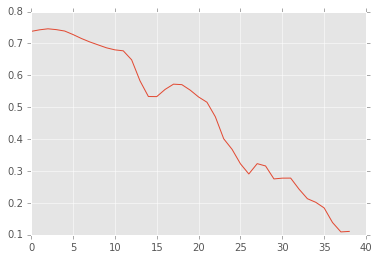

In [5]:
plt.plot(Xs[100,1:1000])

In [85]:
n_classes=5 #0--> not playing, 1,2,3,4 --> strings
dsViolin = datasets.Dataset(Xs=Xs, ys=ys, split=[0.8, 0.1, 0.1], one_hot=True, n_classes=n_classes)
ds=dsViolin

In [94]:
tf.reset_default_graph()

# Create the input to the network.  This is a 4-dimensional tensor!
# Recall that we are using sliding windows of our magnitudes (TODO):
X = tf.placeholder(name='X', shape=(None,n_input), dtype=tf.float32)

# Create the output to the network.  This is our one hot encoding of 2 possible values (TODO)!
Y = tf.placeholder(name='Y', shape=(None,n_classes), dtype=tf.float32)

if (joinWithPitch):
    X_pitch = tf.placeholder(name='X_pitch', shape=(None,1), dtype=tf.float32)

In [95]:
n_neurons=[100, 80, 60, 40, 20, 10]
h1, W1 = utils.linear(x=X, n_output=n_neurons[0], name='layer1', activation=tf.nn.relu)
h2, W2 = utils.linear(x=h1, n_output=n_neurons[1], name='layer2', activation=tf.nn.relu)
h3, W3 = utils.linear(x=h2, n_output=n_neurons[2], name='layer3', activation=tf.nn.relu)
h4, W4 = utils.linear(x=h3, n_output=n_neurons[3], name='layer4', activation=tf.nn.relu)
h5, W5 = utils.linear(x=h4, n_output=n_neurons[4], name='layer5', activation=tf.nn.relu)
h6, W6 = utils.linear(x=h5, n_output=n_neurons[5], name='layer6', activation=tf.nn.relu)

if (joinWithPitch):
    #join this branch with the pitch
    joint = tf.concat(1, [X_pitch, h6])
    Y_pred, W7 = utils.linear(joint, n_classes, activation=tf.nn.softmax, name='pred')
else:
    Y_pred, W7 = utils.linear(h6, n_classes, activation=tf.nn.softmax, name='pred')

#Y_pred , W= utils.linear(x=X, n_output=n_classes, activation=tf.nn.softmax, name='pred')

In [96]:
#loss = tf.squared_difference(Y_pred,Y)
#loss = utils.binary_cross_entropy(Y_pred,Y)
#sum_loss = tf.reduce_sum(loss, 1)
#cost = tf.reduce_mean(tf.reduce_sum(loss, 1))
cross_entropy= -tf.reduce_sum(Y * tf.log(Y_pred + 1e-12) )

In [97]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

predicted_y = tf.argmax(Y_pred,1)
actual_y = tf.argmax(Y,1)
correct_prediction = tf.equal(predicted_y, actual_y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

(5, 40) (5, 5)


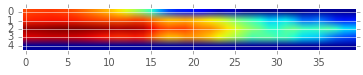

In [98]:
Xs_i, ys_i = next(ds.train.next_batch(5))
print(Xs_i.shape, ys_i.shape)
plt.imshow(Xs_i)
#plt.plot(ys_i)

In [60]:
Xs_i[:,0:-1].shape

(200, 40)

In [137]:
# Explore these parameters: (TODO)
n_epochs = 100
batch_size = 4000

# Create a session and init!
sess = tf.Session()


In [138]:
saver = tf.train.Saver()


In [139]:
sess.run(tf.initialize_all_variables())

Training 1 with accuracy measure

In [142]:
# Now iterate over our dataset n_epoch times
for epoch_i in range(n_epochs):
    print('Epoch: ', epoch_i)
    
    # Train
    this_accuracy = 0
    its = 0
    
    # Do our mini batches:
    for Xs_i, ys_i in ds.train.next_batch(batch_size):
        # Note here: we are running the optimizer so
        # that the network parameters train!
        if (joinWithPitch):
            this_accuracy += sess.run([accuracy, optimizer], feed_dict={
                X:Xs_i[:,0:-1], Y:ys_i, X_pitch:Xs_i[:,-1:]})[0]
        else:
            this_accuracy += sess.run([accuracy, optimizer], feed_dict={
                X:Xs_i, Y:ys_i})[0]
            
        its += 1
        #print(this_accuracy / its)
    print('Training accuracy: ', this_accuracy / its)
    
    # Validation (see how the network does on unseen data).
    this_accuracy = 0
    its = 0
    
    # Do our mini batches:
    for Xs_i, ys_i in ds.valid.next_batch(batch_size):
        # Note here: we are NOT running the optimizer!
        # we only measure the accuracy!
        if (joinWithPitch):
            this_accuracy += sess.run(accuracy, feed_dict={
                X:Xs_i[:,0:-1], Y:ys_i, X_pitch:Xs_i[:,-1:]})
        else:
            this_accuracy += sess.run(accuracy, feed_dict={
                X:Xs_i, Y:ys_i})
            
        its += 1
    print('Validation accuracy: ', this_accuracy / its)

Epoch:  0
Training accuracy:  0.874453485012
Validation accuracy:  0.879999995232
Epoch:  1
Training accuracy:  0.847595274448
Validation accuracy:  0.939999997616
Epoch:  2
Training accuracy:  0.89006870985
Validation accuracy:  0.920000016689
Epoch:  3
Training accuracy:  0.862585902214
Validation accuracy:  0.910000026226
Epoch:  4
Training accuracy:  0.860087454319
Validation accuracy:  0.939999997616
Epoch:  5
Training accuracy:  0.902560889721
Validation accuracy:  0.889999985695
Epoch:  6
Training accuracy:  0.853841364384
Validation accuracy:  0.944999992847
Epoch:  7
Training accuracy:  0.897563993931
Validation accuracy:  0.944999992847
Epoch:  8
Training accuracy:  0.887570261955
Validation accuracy:  0.915000021458
Epoch:  9
Training accuracy:  0.862585902214
Validation accuracy:  0.939999997616
Epoch:  10
Training accuracy:  0.906308531761
Validation accuracy:  0.910000026226
Epoch:  11
Training accuracy:  0.863210499287
Validation accuracy:  0.939999997616
Epoch:  12
Trai

Training 2 base case

In [ ]:
import datetime
now = datetime.datetime.now()
save_path = saver.save(sess, "./models/string_ffnet_"+ now.strftime("%Y%m%d_%H%M") + ".ckpt")
print("Model saved in file: %s" % save_path)

In [111]:
Xs_i, ys_i = next(ds.train.next_batch(20))
#ys_pred = Y_pred.eval(feed_dict={X: Xs_i}, session=sess)
if joinWithPitch:
    prediction = sess.run([predicted_y], feed_dict={X:Xs_i[:,0:-1], X_pitch:Xs_i[:,-1:]})
else:
    prediction = sess.run([predicted_y], feed_dict={X:Xs_i})

print("Xs_i.shape:", Xs_i.shape , ", prediction.shape:",  np.array(prediction).shape)

Xs_i.shape: (20, 40) , prediction.shape: (1, 20)


In [133]:
scoreL=len(string)
scoreStart=0
if joinWithPitch:
    Xs_i=np.zeros(shape=(scoreL,41))
    Xs_i[:,0:-1]=energyBand[:,scoreStart:scoreStart+scoreL].T
    Xs_i[:,-1] = pitch[scoreStart:scoreStart+scoreL]
else:
    Xs_i=np.zeros(shape=(scoreL,40))
    Xs_i=energyBand[:,scoreStart:scoreStart+scoreL].T

ys_i=string[scoreStart:scoreStart+scoreL] ##np.zeros(shape=(scoreL,5))


In [128]:
if joinWithPitch:
    prediction=sess.run([predicted_y], feed_dict={X:Xs_i[:,0:-1], X_pitch:Xs_i[:,-1:]})[0] #, keep_prob: 1.0
else:
    prediction=sess.run([predicted_y], feed_dict={X:Xs_i})[0] #, keep_prob: 1.0

#linPrediction = np.reshape(prediction, (np.product(prediction.shape)))
#linOriginal = np.reshape(ys_i, (np.product(ys_i.shape)))
prediction.shape

(1000,)

(0, 4)

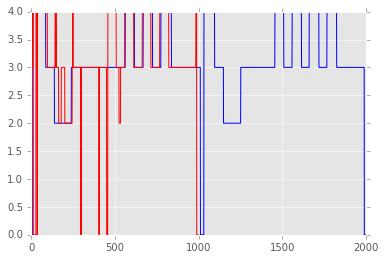

In [136]:
plt.plot(ys_i,'b')
plt.plot(prediction, 'r')
plt.ylim((0, 4))

(0, 4)

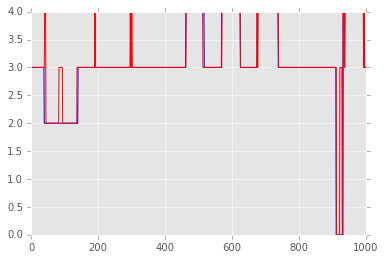

In [82]:
plt.plot(linOriginal,'b')
plt.plot(linPrediction, 'r')
plt.ylim((0, 4))

In [ ]:
predProb=sess.run([Y_pred], feed_dict={X:Xs_i})[0] #, keep_prob: 1.0
predProb[100,:]

In [ ]:
plt.plot(prediction)